# Experiments on Scenario A with FastAI: Round 2

This series of experiments was performed on a rebalanced subset of the Data from Scenario A where the new dataset is created by reducing a random sample of Non-Tor data to the equivalent size of the Tor data. The new dataset is comprised of exactly 50% Tor connection data and 50% Non-Tor connection data.

This is the second round of experiments conducted due to the surprising accuracy of the first set of tests. 

The experiments are executed on the full, unbalanced dataset then are executed on the balanced dataset. The experiments are executed on 6 sets of data, and are conducted in 3 rounds, each with an increasing number of training cycles. This will help compensate for under/over-fitting 

In [1]:
import os, sys, glob, pprint
from fastai.tabular import *
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import pandas as pd
import numpy as np

RANDOM_STATE: int = 1

# set up pretty printer for easier data evaluation
p = pprint.PrettyPrinter(indent=4, width=30)
pretty = p.pprint

print('libraries loaded')

libraries loaded


##  Prepare the data

The balanced datasets have already been balanced and cleaned for use, but we will do some re-cleaning to make sure the experiments without throwing an error. The files and their path are listed here

In [2]:
dataPath: str = './finished_data/all_features/'

one_to_one:   str = dataPath + 'one_one/'
    
data: list = [
    'merged_5s.csv',
    'SelectedFeatures-10s-TOR-NonTor.csv',
    'TimeBasedFeatures-15s-TOR-NonTOR.csv',
    'TimeBasedFeatures-30s-TORNonTor.csv',
    'TimeBasedFeatures-60s-TOR-NonTor.csv',
    'TimeBasedFeatures-120s-TOR-NonTor.csv',
]

Here we create a helper function assist in mapping over the data list

In [3]:
def set_data_path(dataPath):
    def get_file_path(file):
        return os.path.join(dataPath, file)
    
    return get_file_path

In [4]:
csv_files:              list = list(map(set_data_path(dataPath), data))
csv_files_one_to_one:   list = list(map(set_data_path(one_to_one), data))

    
data_info: str = f'''
We will be using {len(data)} datasets to run experiments with the following configurations:
\t1. full, clean dataset for baseline comparison
\t2. a one to one, TOR to non-TOR dataset
'''
    
    
print(data_info)
pretty(data)


We will be using 6 datasets to run experiments with the following configurations:
	1. full, clean dataset for baseline comparison
	2. a one to one, TOR to non-TOR dataset

[   'merged_5s.csv',
    'SelectedFeatures-10s-TOR-NonTor.csv',
    'TimeBasedFeatures-15s-TOR-NonTOR.csv',
    'TimeBasedFeatures-30s-TORNonTor.csv',
    'TimeBasedFeatures-60s-TOR-NonTor.csv',
    'TimeBasedFeatures-120s-TOR-NonTor.csv']


Here we create a series of helper functions to load and reclean the data

In [5]:
def clean_data(df):
    
    # Create a new dataframe and strip off all leading and trailing whitespace
    ndf = df.rename(str.strip, axis='columns')
    
    # Here we create a dictionary that maps possible column names to desired column names
    columns: dict = {
        'duration'           : 'Flow Duration' ,
        'total_fiat'         : 'Fwd IAT Total' , 'total_biat'  : 'Bwd IAT Total' ,
        'min_fiat'           : 'Fwd IAT Min'   , 'min_biat'    : 'Bwd IAT Min'   ,
        'max_fiat'           : 'Fwd IAT Max'   , 'max_biat'    : 'Bwd IAT Max'   ,
        'mean_fiat'          : 'Fwd IAT Mean'  , 'mean_biat'   : 'Bwd IAT Mean'  ,
        'std_fiat'           : 'Fwd IAT Std'   , 'std_biat'    : 'Bwd IAT Std'   ,
        'flowPktsPerSecond'  : 'Flow Packets/s', 'fp_psec'     : 'Flow Packets/s',
        'flowBytesPerSecond' : 'Flow Bytes/s'  , 'fb_psec'     : 'Flow Bytes/s'  ,
        'min_flowiat'        : 'Flow IAT Min'  , 'max_flowiat' : 'Flow IAT Max'  ,
        'mean_flowiat'       : 'Flow IAT Mean' , 'std_flowiat' : 'Flow IAT Std'  ,
        'min_active'         : 'Active Min'    , 'min_idle'    : 'Idle Min'      , 
        'mean_active'        : 'Active Mean'   , 'mean_idle'   : 'Idle Mean'     ,
        'max_active'         : 'Active Max'    , 'max_idle'    : 'Idle Max'      ,
        'std_active'         : 'Active Std'    , 'std_idle'    : 'Idle Std'      ,
        'label'              : 'Label'         , 'class1'      : 'Label'
    }
        
    # Replace old column names
    ndf.rename(columns = columns, inplace = True)
    
    # drop missing values/NaN etc.
    ndf.dropna(inplace=True)
    
    # Search through dataframe for any Infinite or NaN values in various forms that were not picked up previously
    for col in ndf.columns:
        indexNames = ndf[ndf[col] == np.inf].index
        if not indexNames.empty:
            print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)

        indexNames = ndf[ndf[col] == np.nan].index
        if not indexNames.empty:
            print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)

        indexNames = ndf[ndf[col]=='Infinity'].index
        if not indexNames.empty:
            print('deleting {} rows with Infinity in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)

        indexNames = ndf[ndf[col]=='inf'].index
        if not indexNames.empty:
            print('deleting {} rows with inf in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)

        indexNames = ndf[ndf[col]=='NaN'].index
        if not indexNames.empty:
            print('deleting {} rows with NaN in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)

        indexNames = ndf[ndf[col]=='nan'].index
        if not indexNames.empty:
            print('deleting {} rows with nan in column {}'.format(len(indexNames), col))
            ndf.drop(indexNames, inplace=True)
    
    # drop Protocol if it is present
    if 'Protocol' in ndf.columns:
        ndf.drop(columns=['Protocol'], inplace=True)
        
    # drop  Source IP and Destination IP columns if they are present        
    if 'Source IP' in ndf.columns:
        ndf.drop(columns=['Source IP'], inplace=True)

    if 'Destination IP' in ndf.columns:
        ndf.drop(columns=['Destination IP'], inplace=True)
        
    # drop  Source Port and Destination Port columns if they are present        
    if 'Source Port' in ndf.columns:
        ndf.drop(columns=['Source Port'], inplace=True)

    if 'Destination Port' in ndf.columns:
        ndf.drop(columns=['Destination Port'], inplace=True)
            
    # convert  Flow Bytes/s object & Flow Packets/s object into float type if they are present
    if 'Flow Bytes/s' in ndf.columns:
        ndf['Flow Bytes/s'] = ndf['Flow Bytes/s'].astype('float64')

    if 'Flow Packets/s' in df.columns:
        ndf['Flow Packets/s'] = ndf['Flow Packets/s'].astype('float64')
    
    # Finally we standardize the contents of the Label column to being TOR or nonTOR
    ndf = ndf.replace( ['nonTOR', 'non-TOR', 'NONTOR', 'NON-TOR', 'nontor', 'non-tor', 'nonTor', 'non-Tor'], 'nonTOR')
    
    ndf = ndf.replace( ['TOR', 'tor', 'Tor'], 'TOR')
    
    return ndf

In [6]:
def load_data(filePath):
    
    print(f'Loading Dataset: {filePath}')
    
    df = pd.read_csv(filePath, low_memory=False)
    df = clean_data(df)
    
    return df

Now we can load all of the data in, both balanced and unbalanced versions of the datasets

In [7]:
dataframes: list = list(map(load_data, csv_files))
dataframes_one_to_one: list = list(map(load_data, csv_files_one_to_one))

Loading Dataset: ./finished_data/all_features/merged_5s.csv


/home/nitro/anaconda3/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


Loading Dataset: ./finished_data/all_features/SelectedFeatures-10s-TOR-NonTor.csv
Loading Dataset: ./finished_data/all_features/TimeBasedFeatures-15s-TOR-NonTOR.csv
Loading Dataset: ./finished_data/all_features/TimeBasedFeatures-30s-TORNonTor.csv
Loading Dataset: ./finished_data/all_features/TimeBasedFeatures-60s-TOR-NonTor.csv
Loading Dataset: ./finished_data/all_features/TimeBasedFeatures-120s-TOR-NonTor.csv
Loading Dataset: ./finished_data/all_features/one_one/merged_5s.csv
Loading Dataset: ./finished_data/all_features/one_one/SelectedFeatures-10s-TOR-NonTor.csv
Loading Dataset: ./finished_data/all_features/one_one/TimeBasedFeatures-15s-TOR-NonTOR.csv
Loading Dataset: ./finished_data/all_features/one_one/TimeBasedFeatures-30s-TORNonTor.csv
Loading Dataset: ./finished_data/all_features/one_one/TimeBasedFeatures-60s-TOR-NonTor.csv
Loading Dataset: ./finished_data/all_features/one_one/TimeBasedFeatures-120s-TOR-NonTor.csv


Here we create a function to run the experiments

In [8]:
def run_experiment(experiment_number: int, df, cycles: int, proportions: str):
    try:
        dep_var = 'Label'
        x = df[df[dep_var]=='TOR']
    except:
        dep_var = 'class1'
        x = df[df[dep_var]=='TOR']

    unused_categories: list = []
        
    if 'Source Port' in df.columns:
        unused_categories.append('Source Port')
    if 'Source IP' in df.columns:
        unused_categories.append('Source IP')
    if 'Destination Port' in df.columns:
        unused_categories.append('Destination Port')
    if 'Destination IP' in df.columns:
        unused_categories.append('Destination IP')
    if 'Protocol' in df.columns:
        unused_categories.append('Protocol')
    if 'Index' in df.columns:
        unused_categories.append('Index')
    if 'Unnamed: 0' in df.columns:
        unused_categories.append('Unnamed: 0')
    
    selected_features = list(set(df) - set(unused_categories) - set([dep_var]))
    print('Selected Features:')
    pretty(selected_features)
    print('\nDependent Variable:', dep_var)
    
    procs = [FillMissing, Categorify, Normalize]
    sss = StratifiedShuffleSplit(n_splits = 1, test_size=0.2, random_state=RANDOM_STATE)
    
    for train_idx, test_idx in sss.split(df.index, df[dep_var]):
        data_fold = (TabularList.from_df(df, path=dataPath, cat_names=unused_categories, cont_names=selected_features, procs=procs)
            .split_by_idxs(train_idx, test_idx)
            .label_from_df(cols=dep_var)
            .databunch())
        
        
        # create model and learn
        model = tabular_learner(data_fold, layers=[50, 28], metrics=accuracy, callback_fns=ShowGraph)
        model.fit_one_cycle(cyc_len=cycles) #
        model.save('{}.model'.format(os.path.basename(data[experiment_number] + proportions)))
    
    loss, acc = model.validate()
    print('loss {}: accuracy: {:.2f}%'.format(loss, acc*100))
    
    preds, y, losses = model.get_preds(with_loss=True)
    interp = ClassificationInterpretation(model, preds, y, losses)
    interp.plot_confusion_matrix()


def experiment_metadata(experiment_number, df):
    print(f'Experiment #{experiment_number + 1}\n\ndataset:\t\t{data[experiment_number]}\nshape:\t\t\t{df.shape}')
    try:
        id_column = 'Label'
        tor_data = df[df[id_column]=='TOR']
        non_tor_data = df[df[id_column]=='nonTOR']
        if len(non_tor_data.index) == 0:
            non_tor_data = df[df[id_column] == 'NONTOR']
    except:
        id_column = 'class1'
        tor_data = df[df[id_column]=='TOR']
        non_tor_data = df[df[id_column]=='nonTOR']
        if len(non_tor_data.index) == 0:
            non_tor_data = df[df[id_column] == 'NONTOR']
    print(f'total TOR data:\t\t{len(tor_data.index)}\ntotal Non-TOR data:\t{len(non_tor_data.index)}\n\n')


Next we create a generator to run the experiments with the function above

In [9]:
def run_experiments(dataframes, cycles: int, proportion: str):
    for experiment_number, df in enumerate(dataframes):
        experiment_metadata(experiment_number, df)
        yield run_experiment(experiment_number, df, cycles, proportion)

With our experiment generator, we now set up the experiments

## Experiment Set #1

The first set of experiments are executed on the balanced and unbalanced datasets with 10 cycles of training

In [10]:
experiment = run_experiments(dataframes, 10, 'all')
one_to_one_experiment = run_experiments(dataframes_one_to_one, 10, '_one_to_one')

### Experiment #1

This experiment is run on the 5s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #1

dataset:		merged_5s.csv
shape:			(84187, 24)
total TOR data:		14507
total Non-TOR data:	69680


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.208755,0.276014,0.861860,00:12
1,0.182682,0.344176,0.863998,00:12
2,0.154919,0.281261,0.838164,00:12
3,0.150956,0.325837,0.875757,00:12
4,0.136579,0.260278,0.878370,00:12
5,0.145468,0.347608,0.873857,00:12
6,0.129658,0.372124,0.854496,00:12
7,0.124607,0.450779,0.866789,00:12
8,0.117555,0.356287,0.873144,00:13
9,0.123823,0.296836,0.877836,00:12


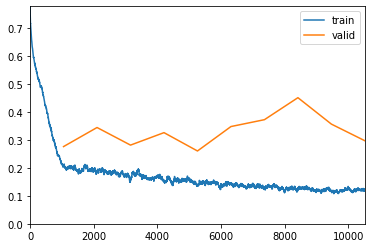

loss 0.29683631658554077: accuracy: 87.78%


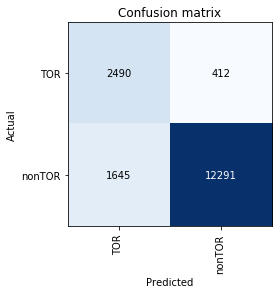

In [11]:
next(experiment)

Experiment #1

dataset:		merged_5s.csv
shape:			(29014, 24)
total TOR data:		14507
total Non-TOR data:	14507


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.327687,0.324963,0.861623,00:05
1,0.264954,0.348854,0.872135,00:05
2,0.248965,0.283866,0.917973,00:05
3,0.232191,0.343310,0.886610,00:05
4,0.235496,0.260941,0.896088,00:05
5,0.205610,0.230815,0.905394,00:05
6,0.189847,0.296258,0.891952,00:05
7,0.196587,0.318560,0.893676,00:05
8,0.181919,0.254519,0.907289,00:05
9,0.169289,0.228408,0.904877,00:05


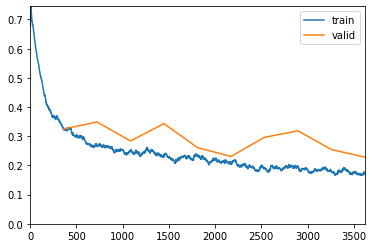

loss 0.22840802371501923: accuracy: 90.49%


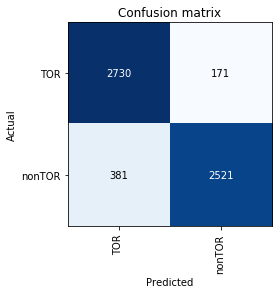

In [12]:
next(one_to_one_experiment)

### Experiment #2

This experiment is run on the 10s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(67828, 24)
total TOR data:		8044
total Non-TOR data:	59784


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.221632,0.223904,0.899749,00:10
1,0.169838,0.235553,0.903583,00:11
2,0.169533,0.217878,0.897833,00:10
3,0.158876,0.281254,0.909627,00:10
4,0.156551,0.216530,0.909701,00:11
5,0.153486,0.256285,0.901961,00:10
6,0.133427,0.227208,0.873360,00:10
7,0.121126,0.233747,0.906900,00:10
8,0.114443,0.292436,0.877709,00:10
9,0.121134,0.235962,0.868126,00:10


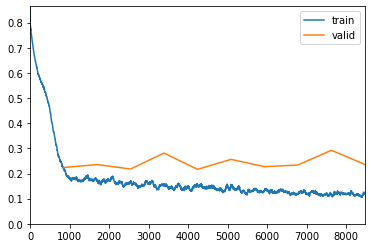

loss 0.23596175014972687: accuracy: 86.81%


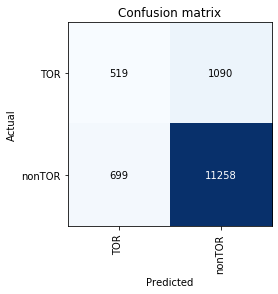

In [13]:
next(experiment)

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(16088, 24)
total TOR data:		8044
total Non-TOR data:	8044


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.359801,0.346968,0.850839,00:03
1,0.292065,0.319806,0.876942,00:03
2,0.272200,0.303361,0.875699,00:03
3,0.258571,0.302509,0.879117,00:03
4,0.246672,0.295936,0.875078,00:03
5,0.238583,0.302926,0.885333,00:03
6,0.226402,0.321014,0.877874,00:03
7,0.220677,0.301938,0.886576,00:03
8,0.201982,0.298180,0.879739,00:03
9,0.204517,0.294582,0.885022,00:03


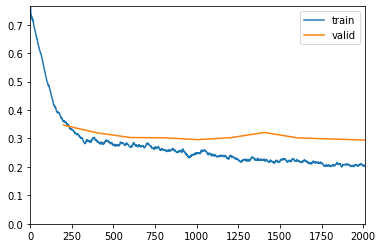

loss 0.2945821285247803: accuracy: 88.50%


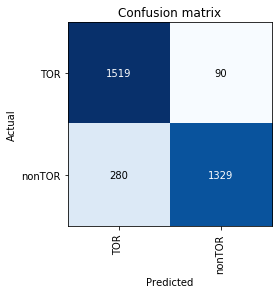

In [14]:
next(one_to_one_experiment)

### Experiment #3

This experiment is run on the 15s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(22072, 24)
total TOR data:		3314
total Non-TOR data:	18758


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.147396,0.054122,0.994337,00:04
1,0.025080,0.016412,0.996149,00:05
2,0.020922,0.019506,0.996376,00:04
3,0.012999,0.013095,0.997055,00:04
4,0.009793,0.022524,0.993658,00:04
5,0.009754,0.011116,0.997055,00:04
6,0.006149,0.029815,0.993432,00:04
7,0.010856,0.022679,0.993885,00:04
8,0.010147,0.021557,0.995243,00:04
9,0.007483,0.015824,0.996602,00:04


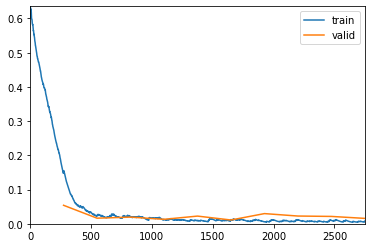

loss 0.01582430861890316: accuracy: 99.66%


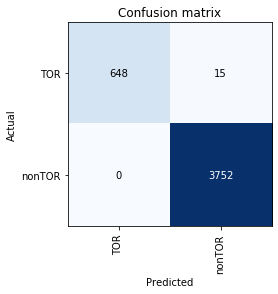

In [15]:
next(experiment)

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(6628, 24)
total TOR data:		3314
total Non-TOR data:	3314


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.268915,0.137906,0.975113,00:02
1,0.106492,0.063634,0.982655,00:02
2,0.057840,0.038780,0.989442,00:02
3,0.043778,0.039737,0.987934,00:02
4,0.041296,0.049156,0.986425,00:02
5,0.040301,0.036642,0.988688,00:02
6,0.031051,0.041091,0.987934,00:04
7,0.025309,0.034244,0.990196,00:02
8,0.021460,0.050711,0.985671,00:02
9,0.021447,0.046120,0.986425,00:02


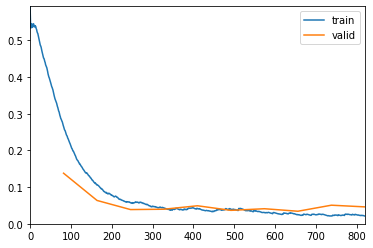

loss 0.04612041637301445: accuracy: 98.64%


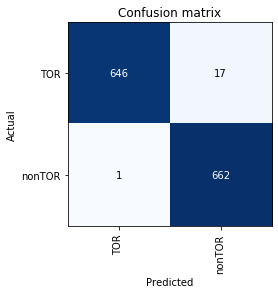

In [16]:
next(one_to_one_experiment)

### Experiment #4

This experiment is run on the 30s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(16422, 24)
total TOR data:		1771
total Non-TOR data:	14651


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.289640,0.127994,0.996956,00:03
1,0.030566,0.016125,0.997260,00:03
2,0.023515,0.012701,0.997565,00:03
3,0.010788,0.016527,0.997565,00:03
4,0.012325,0.015751,0.997565,00:03
5,0.009737,0.022157,0.996651,00:03
6,0.006910,0.021201,0.996956,00:03
7,0.006058,0.019575,0.997260,00:03
8,0.006196,0.019015,0.997260,00:03
9,0.003735,0.011249,0.997869,00:03


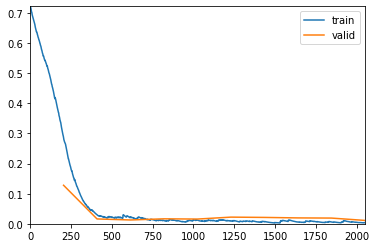

loss 0.011249186471104622: accuracy: 99.79%


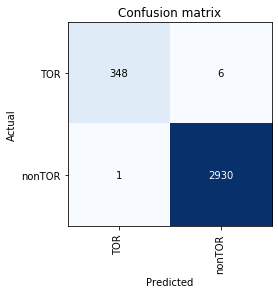

In [17]:
next(experiment)

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(3542, 24)
total TOR data:		1771
total Non-TOR data:	1771


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.561393,0.285375,0.957687,00:02
1,0.258939,0.068338,0.987306,00:02
2,0.136743,0.039989,0.988716,00:02
3,0.083299,0.039482,0.988716,00:02
4,0.063551,0.067246,0.987306,00:02
5,0.054848,0.033046,0.990127,00:02
6,0.045094,0.035300,0.990127,00:02
7,0.040182,0.033288,0.990127,00:02
8,0.042275,0.034007,0.990127,00:02
9,0.036280,0.036959,0.990127,00:02


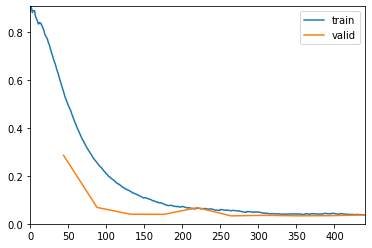

loss 0.03695932775735855: accuracy: 99.01%


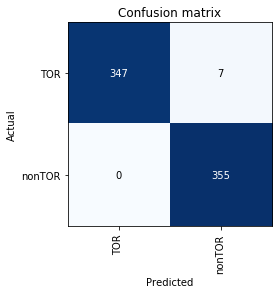

In [18]:
next(one_to_one_experiment)

### Experiment #5

This experiment is run on the 60s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(16429, 24)
total TOR data:		914
total Non-TOR data:	15515


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.399648,0.225221,0.996957,00:03
1,0.045842,0.017684,0.998478,00:03
2,0.006801,0.010144,0.998478,00:03
3,0.005215,0.009613,0.998478,00:03
4,0.003091,0.011032,0.998478,00:03
5,0.001666,0.011324,0.998478,00:04
6,0.004339,0.010206,0.998478,00:05
7,0.003525,0.008027,0.998783,00:04
8,0.003471,0.010162,0.998478,00:06
9,0.004024,0.010970,0.998478,00:05


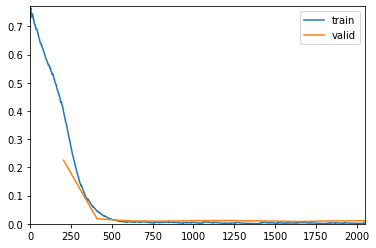

loss 0.01097031868994236: accuracy: 99.85%


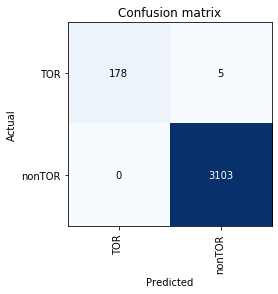

In [19]:
next(experiment)

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(1828, 24)
total TOR data:		914
total Non-TOR data:	914


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.715002,0.539528,0.882514,00:01
1,0.411062,0.124895,0.983607,00:01
2,0.241628,0.069918,0.986339,00:01
3,0.156061,0.065863,0.986339,00:01
4,0.108292,0.055933,0.986339,00:01
5,0.078578,0.059630,0.986339,00:01
6,0.059582,0.057225,0.986339,00:01
7,0.046927,0.058333,0.986339,00:01
8,0.040797,0.055274,0.986339,00:01
9,0.037398,0.056911,0.986339,00:01


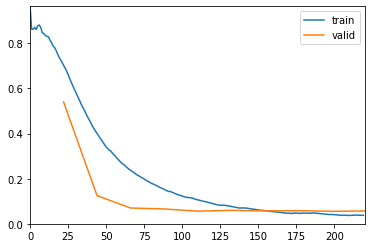

loss 0.05691082403063774: accuracy: 98.63%


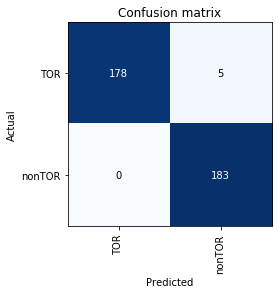

In [20]:
next(one_to_one_experiment)

### Experiment #6

This experiment is run on the 120s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(11252, 24)
total TOR data:		470
total Non-TOR data:	10782


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.539870,0.370175,0.990227,00:03
1,0.132413,0.049202,0.994669,00:03
2,0.023982,0.014796,0.998667,00:03
3,0.009083,0.000866,1.000000,00:03
4,0.005848,0.000678,1.000000,00:03
5,0.006349,0.001441,1.000000,00:03
6,0.004667,0.004688,0.997335,00:03
7,0.004417,0.000239,1.000000,00:03
8,0.002312,0.000128,1.000000,00:03
9,0.004443,0.000216,1.000000,00:03


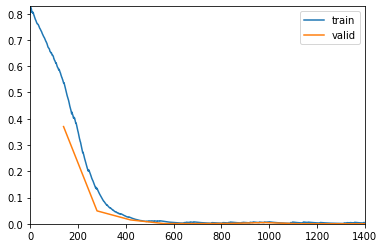

loss 0.00021614728029817343: accuracy: 100.00%


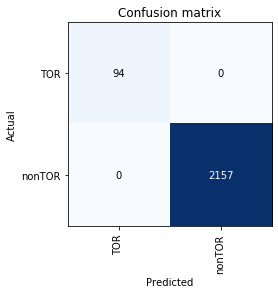

In [21]:
next(experiment)

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(940, 24)
total TOR data:		470
total Non-TOR data:	470


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.637730,0.689079,0.489362,00:01
1,0.484049,0.368975,0.973404,00:01
2,0.348502,0.107910,0.989362,00:01
3,0.258721,0.054004,0.994681,00:01
4,0.201500,0.037041,0.994681,00:01
5,0.162423,0.029431,0.994681,00:01
6,0.134823,0.027585,1.000000,00:01
7,0.114281,0.025486,1.000000,00:01
8,0.097005,0.024136,0.994681,00:03
9,0.085562,0.023945,0.994681,00:01


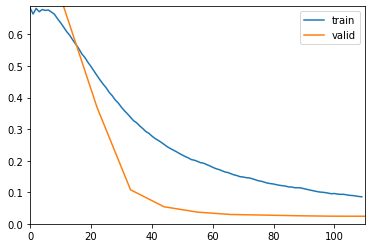

loss 0.023944729939103127: accuracy: 99.47%


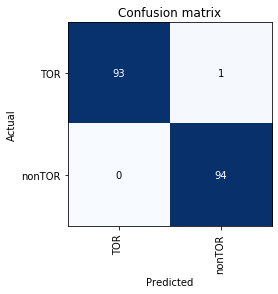

In [22]:
next(one_to_one_experiment)

## Experiment Set #2

The first set of experiments are executed on the balanced and unbalanced datasets with 15 cycles of training

In [23]:
experiment = run_experiments(dataframes, 15, '_all_15')
one_to_one_experiment = run_experiments(dataframes_one_to_one, 15, '_one_to_one_15')

### Experiment #1

This experiment is run on the 5s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #1

dataset:		merged_5s.csv
shape:			(84187, 24)
total TOR data:		14507
total Non-TOR data:	69680


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.266919,0.264319,0.912935,00:13
1,0.190806,0.226506,0.894702,00:12
2,0.170560,0.488295,0.867146,00:12
3,0.161751,0.214148,0.918636,00:12
4,0.142933,0.440149,0.872669,00:12
5,0.145163,0.538655,0.831987,00:12
6,0.147739,0.410327,0.865542,00:12
7,0.139816,0.388461,0.857643,00:12
8,0.138699,0.816251,0.874213,00:12
9,0.128687,0.314284,0.876351,00:12


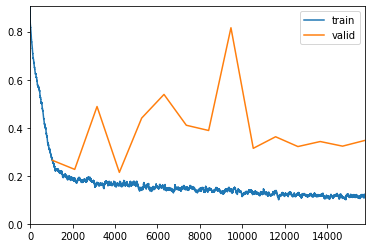

loss 0.3471425175666809: accuracy: 87.66%


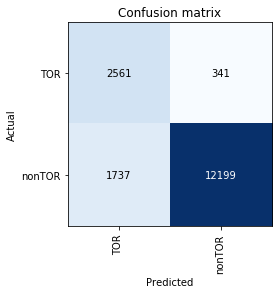

In [24]:
next(experiment)

Experiment #1

dataset:		merged_5s.csv
shape:			(29014, 24)
total TOR data:		14507
total Non-TOR data:	14507


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.368728,0.357827,0.849733,00:05
1,0.271448,0.339237,0.863174,00:07
2,0.256514,0.267961,0.889023,00:07
3,0.255059,0.336865,0.877305,00:05
4,0.245344,0.368762,0.870929,00:05
5,0.231580,0.329194,0.884887,00:05
6,0.224360,0.362091,0.885921,00:05
7,0.214517,0.331104,0.886093,00:05
8,0.189618,0.331239,0.882992,00:05
9,0.171756,0.330756,0.895916,00:05


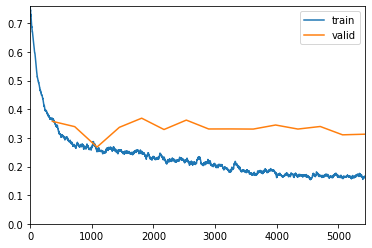

loss 0.31289276480674744: accuracy: 89.21%


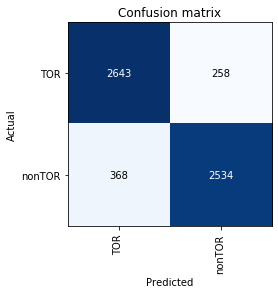

In [25]:
next(one_to_one_experiment)

### Experiment #2

This experiment is run on the 10s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(67828, 24)
total TOR data:		8044
total Non-TOR data:	59784


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.275055,0.311734,0.881321,00:10
1,0.172069,0.222294,0.898865,00:10
2,0.163603,0.228411,0.901519,00:10
3,0.152260,0.247371,0.905130,00:10
4,0.149839,0.212935,0.906457,00:10
5,0.143829,0.225680,0.904320,00:10
6,0.139861,0.254191,0.906236,00:10
7,0.135163,0.287178,0.905573,00:10
8,0.126044,0.321027,0.909037,00:10
9,0.113540,0.340275,0.903951,00:10


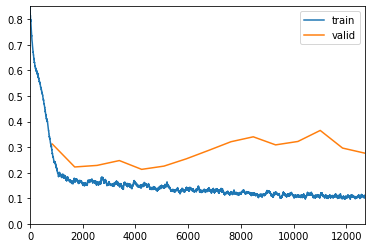

loss 0.27629774808883667: accuracy: 90.44%


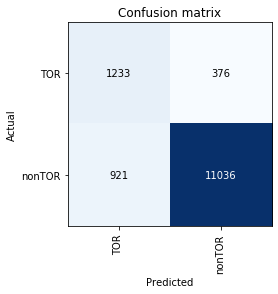

In [26]:
next(experiment)

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(16088, 24)
total TOR data:		8044
total Non-TOR data:	8044


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.375382,0.358513,0.850839,00:03
1,0.296902,0.321410,0.865134,00:03
2,0.291945,0.326169,0.873524,00:04
3,0.276634,0.292973,0.888440,00:03
4,0.258522,0.316776,0.879428,00:03
5,0.239112,0.310768,0.869484,00:03
6,0.236046,0.311420,0.883157,00:07
7,0.239560,0.290022,0.879428,00:03
8,0.245220,0.303601,0.881914,00:03
9,0.218826,0.287984,0.882536,00:03


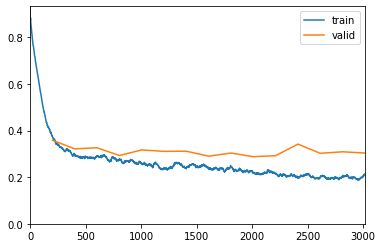

loss 0.30344435572624207: accuracy: 87.54%


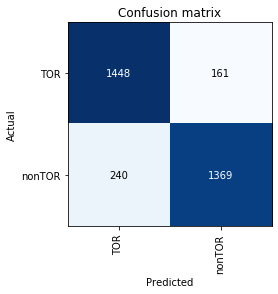

In [27]:
next(one_to_one_experiment)

### Experiment #3

This experiment is run on the 15s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(22072, 24)
total TOR data:		3314
total Non-TOR data:	18758


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.255450,0.197349,0.946319,00:04
1,0.052109,0.030418,0.995696,00:04
2,0.018294,0.015037,0.996376,00:04
3,0.016593,0.015707,0.996602,00:05
4,0.017212,0.013254,0.997282,00:08
5,0.011883,0.024231,0.994337,00:05
6,0.009189,0.017062,0.997055,00:05
7,0.007097,0.028924,0.993885,00:05
8,0.008547,0.033211,0.993658,00:05
9,0.009659,0.031479,0.992525,00:04


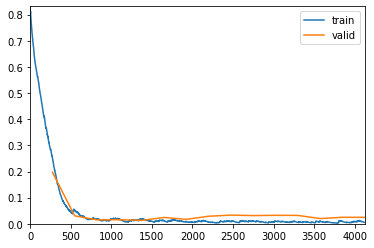

loss 0.02465524524450302: accuracy: 99.39%


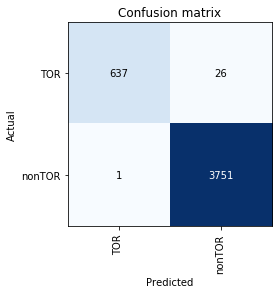

In [28]:
next(experiment)

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(6628, 24)
total TOR data:		3314
total Non-TOR data:	3314


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.356988,0.227234,0.947964,00:02
1,0.150069,0.068507,0.981900,00:02
2,0.083638,0.045155,0.986425,00:02
3,0.051866,0.057544,0.987179,00:02
4,0.040299,0.043292,0.987179,00:02
5,0.032540,0.047853,0.987179,00:02
6,0.028353,0.051592,0.985671,00:02
7,0.028078,0.059588,0.985671,00:02
8,0.025447,0.058175,0.984917,00:02
9,0.025763,0.024083,0.992459,00:02


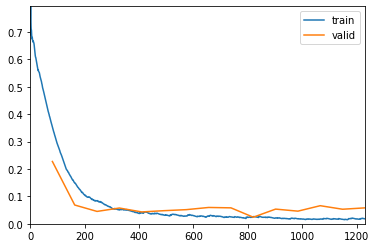

loss 0.05806741490960121: accuracy: 98.57%


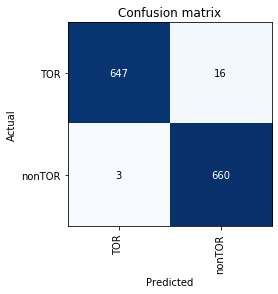

In [29]:
next(one_to_one_experiment)

### Experiment #4

This experiment is run on the 30s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(16422, 24)
total TOR data:		1771
total Non-TOR data:	14651


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.351789,0.225785,0.993303,00:03
1,0.058233,0.023272,0.997565,00:03
2,0.016147,0.017661,0.997260,00:03
3,0.016718,0.024303,0.992998,00:03
4,0.012538,0.016584,0.997565,00:03
5,0.009414,0.010346,0.997869,00:03
6,0.008045,0.014661,0.997565,00:03
7,0.010973,0.011973,0.997260,00:03
8,0.007787,0.019938,0.997260,00:03
9,0.007064,0.007115,0.998174,00:03


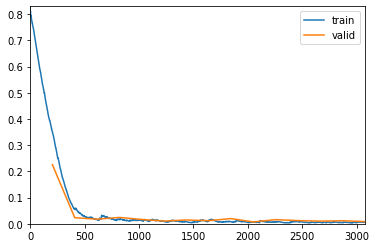

loss 0.008359536528587341: accuracy: 99.82%


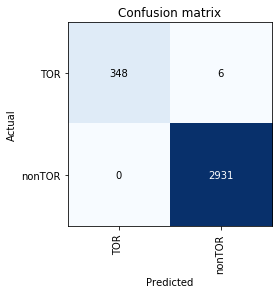

In [30]:
next(experiment)

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(3542, 24)
total TOR data:		1771
total Non-TOR data:	1771


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.732569,0.500124,0.929478,00:02
1,0.365877,0.110562,0.987306,00:02
2,0.187335,0.054586,0.988716,00:02
3,0.106899,0.046764,0.988716,00:02
4,0.073727,0.041114,0.988716,00:04
5,0.056101,0.040553,0.988716,00:02
6,0.053329,0.069928,0.987306,00:02
7,0.048557,0.036301,0.991537,00:02
8,0.038041,0.029580,0.991537,00:02
9,0.037130,0.033668,0.990127,00:02


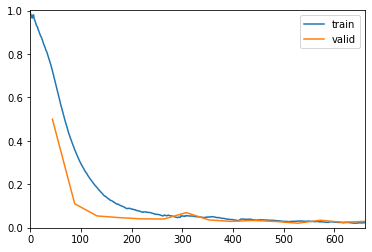

loss 0.029695682227611542: accuracy: 99.15%


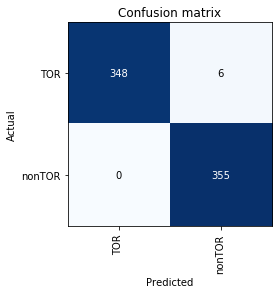

In [31]:
next(one_to_one_experiment)

### Experiment #5

This experiment is run on the 60s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(16429, 24)
total TOR data:		914
total Non-TOR data:	15515


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.537636,0.392622,0.979915,00:04
1,0.109921,0.031941,0.998478,00:03
2,0.015442,0.010941,0.998478,00:03
3,0.007919,0.008255,0.998478,00:04
4,0.006476,0.009622,0.998478,00:03
5,0.003716,0.011342,0.998478,00:07
6,0.001593,0.009117,0.999087,00:04
7,0.004398,0.010441,0.998478,00:03
8,0.003908,0.010096,0.998478,00:03
9,0.002919,0.009111,0.998783,00:05


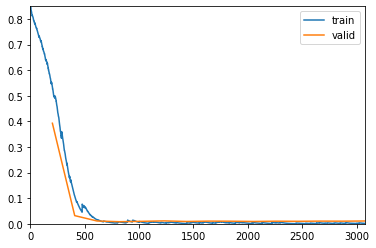

loss 0.010965357534587383: accuracy: 99.85%


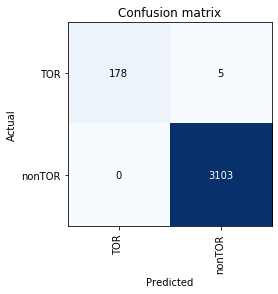

In [32]:
next(experiment)

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(1828, 24)
total TOR data:		914
total Non-TOR data:	914


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.532714,0.550491,0.786885,00:02
1,0.358526,0.177343,0.969945,00:02
2,0.232629,0.087866,0.980874,00:02
3,0.155950,0.061017,0.986339,00:04
4,0.112601,0.070310,0.983607,00:02
5,0.084484,0.072486,0.983607,00:02
6,0.064955,0.053385,0.986339,00:01
7,0.051179,0.063927,0.986339,00:02
8,0.042488,0.062750,0.986339,00:02
9,0.038698,0.052337,0.986339,00:06


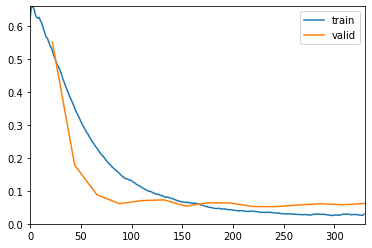

loss 0.061786457896232605: accuracy: 98.63%


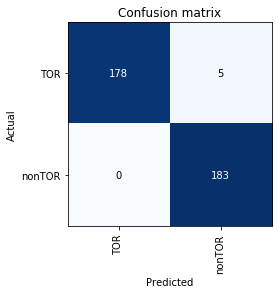

In [33]:
next(one_to_one_experiment)

### Experiment #6

This experiment is run on the 120s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(11252, 24)
total TOR data:		470
total Non-TOR data:	10782


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.630436,0.527793,0.966237,00:03
1,0.273359,0.104125,0.996890,00:03
2,0.049972,0.011826,1.000000,00:03
3,0.011131,0.000991,1.000000,00:03
4,0.006820,0.000767,1.000000,00:03
5,0.004925,0.000989,0.999556,00:03
6,0.005679,0.001042,0.999556,00:03
7,0.004169,0.000315,1.000000,00:03
8,0.003792,0.000328,1.000000,00:03
9,0.003633,0.000762,1.000000,00:03


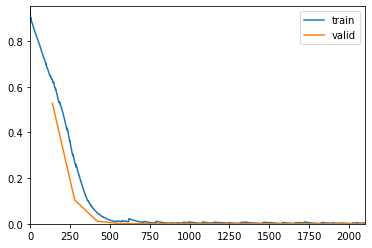

loss 0.0001900799834402278: accuracy: 100.00%


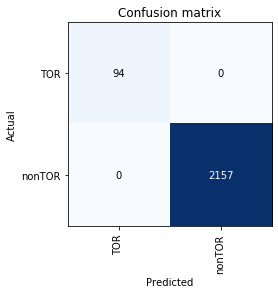

In [34]:
next(experiment)

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(940, 24)
total TOR data:		470
total Non-TOR data:	470


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.613420,0.647743,0.611702,00:01
1,0.501242,0.411715,0.994681,00:01
2,0.374808,0.139866,0.994681,00:01
3,0.281548,0.052535,0.994681,00:01
4,0.216704,0.033236,1.000000,00:01
5,0.172037,0.024440,1.000000,00:01
6,0.139122,0.018135,0.994681,00:01
7,0.115949,0.015967,1.000000,00:01
8,0.099259,0.012912,1.000000,00:01
9,0.084971,0.015091,1.000000,00:01


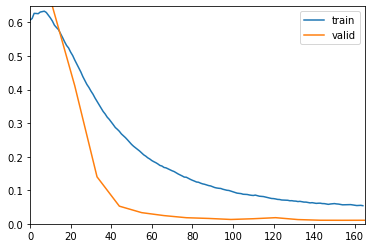

loss 0.010575166903436184: accuracy: 100.00%


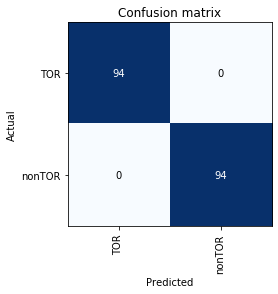

In [35]:
next(one_to_one_experiment)

## Experiment Set #3

The first set of experiments are executed on the balanced and unbalanced datasets with 20 cycles of training

In [36]:
experiment = run_experiments(dataframes, 20, '_all_20')
one_to_one_experiment = run_experiments(dataframes_one_to_one, 20, '_one_to_one_20')

### Experiment #1

This experiment is run on the 5s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #1

dataset:		merged_5s.csv
shape:			(84187, 24)
total TOR data:		14507
total Non-TOR data:	69680


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.290801,0.294481,0.857109,00:13
1,0.198485,0.310624,0.862157,00:13
2,0.195015,0.226740,0.878370,00:16
3,0.196254,0.203091,0.933959,00:14
4,0.166988,0.207152,0.942630,00:13
5,0.160321,0.175548,0.939542,00:13
6,0.150736,0.320163,0.874748,00:13
7,0.151275,0.333717,0.866314,00:13
8,0.148728,0.276600,0.871719,00:15
9,0.139600,0.409836,0.856159,00:13


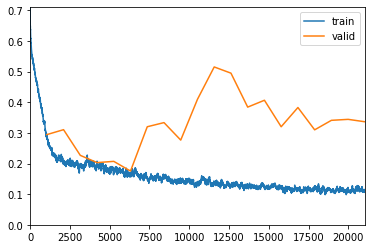

loss 0.3364706039428711: accuracy: 86.05%


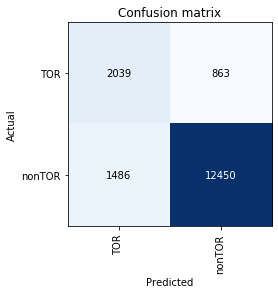

In [37]:
next(experiment)

Experiment #1

dataset:		merged_5s.csv
shape:			(29014, 24)
total TOR data:		14507
total Non-TOR data:	14507


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.370185,0.353825,0.854386,00:05
1,0.299471,0.293725,0.871618,00:05
2,0.262598,0.321011,0.868516,00:05
3,0.253425,0.362912,0.864208,00:05
4,0.234968,0.293150,0.870584,00:08
5,0.232184,0.229163,0.902464,00:05
6,0.230749,0.265976,0.881441,00:05
7,0.207237,0.348302,0.884198,00:06
8,0.213874,0.303637,0.894193,00:05
9,0.196148,0.280992,0.891608,00:05


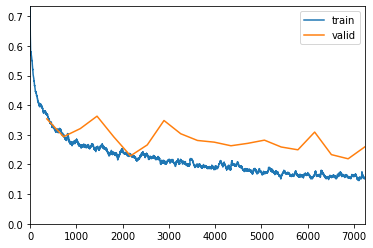

loss 0.2594849169254303: accuracy: 89.47%


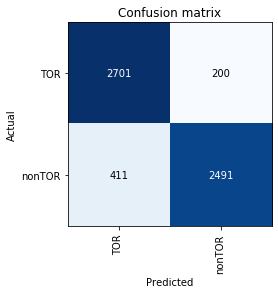

In [38]:
next(one_to_one_experiment)

### Experiment #2

This experiment is run on the 10s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(67828, 24)
total TOR data:		8044
total Non-TOR data:	59784


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.336898,0.328467,0.890830,00:13
1,0.168409,0.210083,0.902256,00:11
2,0.159528,0.235875,0.901224,00:11
3,0.171327,0.203974,0.901740,00:11
4,0.150594,0.221430,0.906015,00:11
5,0.145069,0.251363,0.902993,00:12
6,0.132064,0.290045,0.906531,00:11
7,0.126244,0.231820,0.910659,00:11
8,0.126047,0.248912,0.889872,00:11
9,0.126540,0.272115,0.910143,00:11


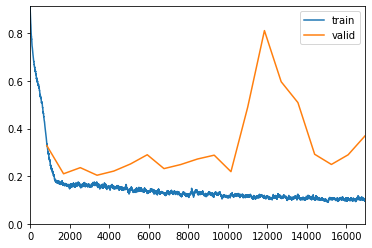

loss 0.36868560314178467: accuracy: 90.88%


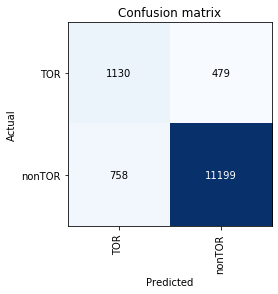

In [39]:
next(experiment)

Experiment #2

dataset:		SelectedFeatures-10s-TOR-NonTor.csv
shape:			(16088, 24)
total TOR data:		8044
total Non-TOR data:	8044


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.409623,0.374944,0.844624,00:03
1,0.311895,0.320248,0.857986,00:04
2,0.282997,0.308679,0.872281,00:03
3,0.273840,0.309206,0.878496,00:04
4,0.260557,0.318540,0.876631,00:05
5,0.255668,0.288182,0.879739,00:04
6,0.240849,0.362240,0.874456,00:06
7,0.237398,0.305233,0.884400,00:04
8,0.236775,0.314285,0.882225,00:03
9,0.228776,0.345626,0.879739,00:04


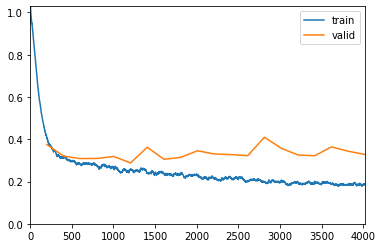

loss 0.3279840350151062: accuracy: 89.00%


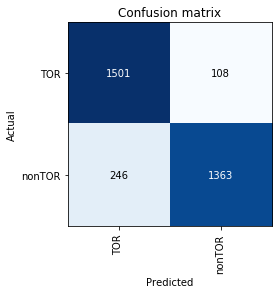

In [40]:
next(one_to_one_experiment)

### Experiment #3

This experiment is run on the 15s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(22072, 24)
total TOR data:		3314
total Non-TOR data:	18758


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.243164,0.194512,0.954247,00:04
1,0.041375,0.022540,0.996829,00:04
2,0.020211,0.015282,0.997055,00:04
3,0.022244,0.011276,0.997055,00:04
4,0.015095,0.030159,0.993658,00:05
5,0.011653,0.028130,0.994564,00:04
6,0.010029,0.024246,0.996829,00:04
7,0.013802,0.035284,0.992978,00:04
8,0.009577,0.060334,0.987995,00:04
9,0.008968,0.033136,0.995243,00:04


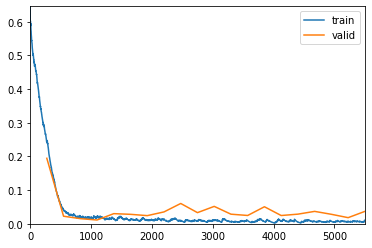

loss 0.03685788810253143: accuracy: 99.30%


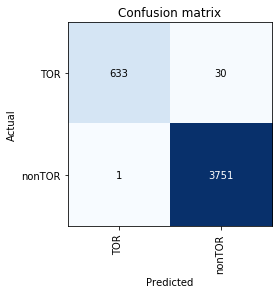

In [41]:
next(experiment)

Experiment #3

dataset:		TimeBasedFeatures-15s-TOR-NonTOR.csv
shape:			(6628, 24)
total TOR data:		3314
total Non-TOR data:	3314


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.417051,0.334673,0.899698,00:02
1,0.188250,0.116841,0.972851,00:02
2,0.096731,0.051280,0.987179,00:02
3,0.059877,0.035400,0.989442,00:02
4,0.051123,0.030946,0.988688,00:02
5,0.038971,0.031788,0.990196,00:02
6,0.039951,0.028500,0.993967,00:02
7,0.031289,0.027154,0.990950,00:02
8,0.034989,0.030633,0.990950,00:02
9,0.031958,0.065526,0.983409,00:02


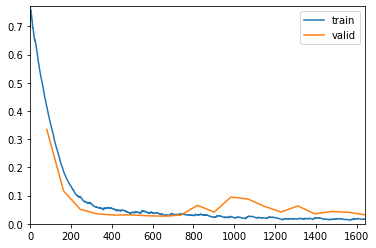

loss 0.03223139047622681: accuracy: 99.10%


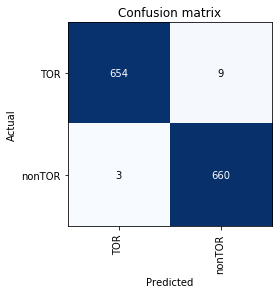

In [42]:
next(one_to_one_experiment)

### Experiment #4

This experiment is run on the 30s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(16422, 24)
total TOR data:		1771
total Non-TOR data:	14651


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.399216,0.349268,0.952816,00:04
1,0.118313,0.069978,0.993303,00:06
2,0.022358,0.014838,0.997565,00:05
3,0.010301,0.015546,0.997260,00:04
4,0.014618,0.013673,0.997565,00:06
5,0.013262,0.008276,0.998174,00:04
6,0.015126,0.011660,0.997260,00:04
7,0.011039,0.009743,0.997565,00:04
8,0.010853,0.009407,0.997869,00:04
9,0.009668,0.008738,0.998174,00:04


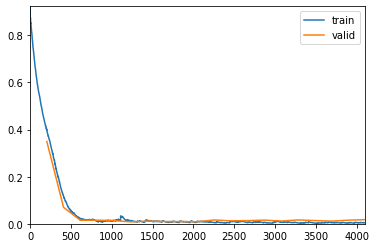

loss 0.017603758722543716: accuracy: 99.79%


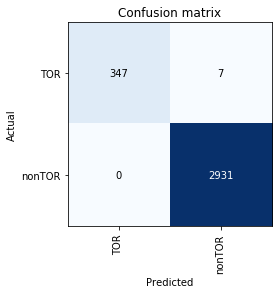

In [43]:
next(experiment)

Experiment #4

dataset:		TimeBasedFeatures-30s-TORNonTor.csv
shape:			(3542, 24)
total TOR data:		1771
total Non-TOR data:	1771


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.501723,0.318897,0.966150,00:02
1,0.285120,0.113123,0.987306,00:02
2,0.163659,0.058353,0.987306,00:02
3,0.100916,0.043251,0.988716,00:02
4,0.070775,0.059890,0.987306,00:02
5,0.056444,0.044203,0.988716,00:02
6,0.049690,0.029366,0.991537,00:02
7,0.043805,0.043822,0.988716,00:02
8,0.040596,0.029398,0.991537,00:02
9,0.037909,0.034260,0.990127,00:02


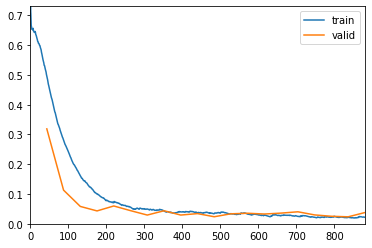

loss 0.037759583443403244: accuracy: 99.15%


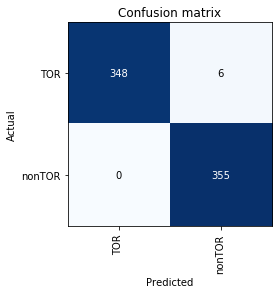

In [44]:
next(one_to_one_experiment)

### Experiment #5

This experiment is run on the 60s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(16429, 24)
total TOR data:		914
total Non-TOR data:	15515


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.456081,0.394257,0.985088,00:04
1,0.153300,0.086060,0.998478,00:04
2,0.020754,0.013146,0.998478,00:04
3,0.012557,0.017264,0.998478,00:04
4,0.005759,0.010040,0.998478,00:04
5,0.005059,0.008821,0.998478,00:04
6,0.011118,0.012637,0.996957,00:04
7,0.005140,0.011811,0.998478,00:04
8,0.004346,0.009941,0.998478,00:04
9,0.002664,0.012283,0.998478,00:03


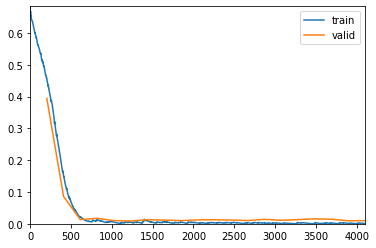

loss 0.009958436712622643: accuracy: 99.88%


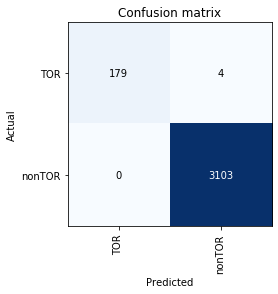

In [45]:
next(experiment)

Experiment #5

dataset:		TimeBasedFeatures-60s-TOR-NonTor.csv
shape:			(1828, 24)
total TOR data:		914
total Non-TOR data:	914


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Bwd IAT Std',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Fwd IAT Mean',
    'Fwd IAT Std',
    'Active Max',
    'Flow IAT Min',
    'Idle Std',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.683322,0.626791,0.740437,00:01
1,0.517039,0.275526,0.969945,00:01
2,0.349664,0.112432,0.980874,00:01
3,0.236573,0.077910,0.986339,00:01
4,0.163851,0.064987,0.986339,00:01
5,0.116156,0.061450,0.986339,00:01
6,0.083222,0.067096,0.986339,00:01
7,0.061663,0.049711,0.986339,00:01
8,0.048171,0.059392,0.986339,00:03
9,0.041112,0.064716,0.986339,00:01


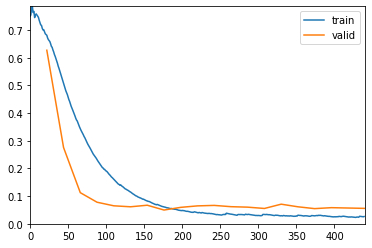

loss 0.055676475167274475: accuracy: 98.63%


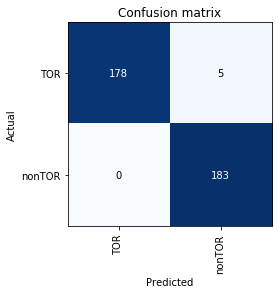

In [46]:
next(one_to_one_experiment)

### Experiment #6

This experiment is run on the 120s dataset, first on the unbalanced dataset as a control, then on the balanced dataset

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(11252, 24)
total TOR data:		470
total Non-TOR data:	10782


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.575908,0.481167,0.983563,00:03
1,0.309467,0.162132,0.999112,00:03
2,0.077142,0.020819,1.000000,00:03
3,0.019786,0.004252,1.000000,00:03
4,0.007815,0.001107,1.000000,00:03
5,0.004764,0.001594,1.000000,00:03
6,0.006993,0.000769,1.000000,00:03
7,0.005785,0.000857,0.999556,00:03
8,0.005941,0.000752,1.000000,00:03
9,0.009329,0.020500,0.998667,00:03


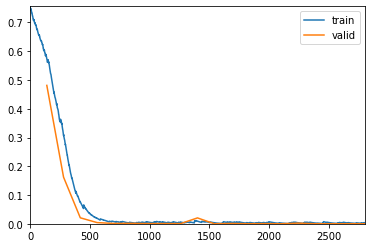

loss 0.0001689814671408385: accuracy: 100.00%


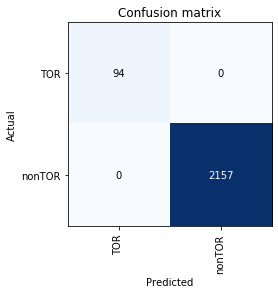

In [47]:
next(experiment)

Experiment #6

dataset:		TimeBasedFeatures-120s-TOR-NonTor.csv
shape:			(940, 24)
total TOR data:		470
total Non-TOR data:	470


Selected Features:
[   'Fwd IAT Min',
    'Active Std',
    'Flow IAT Max',
    'Fwd IAT Max',
    'Active Mean',
    'Bwd IAT Mean',
    'Flow IAT Std',
    'Idle Max',
    'Flow Bytes/s',
    'Flow Packets/s',
    'Idle Min',
    'Bwd IAT Min',
    'Flow IAT Mean',
    'Bwd IAT Total',
    'Fwd IAT Mean',
    'Active Max',
    'Fwd IAT Total',
    'Idle Std',
    'Flow IAT Min',
    'Flow Duration',
    'Idle Mean',
    'Active Min',
    'Bwd IAT Max']

Dependent Variable: Label


epoch,train_loss,valid_loss,accuracy,time
0,0.797765,0.682827,0.675532,00:01
1,0.687906,0.544086,0.914894,00:01
2,0.540827,0.279031,0.984043,00:01
3,0.412143,0.102796,0.989362,00:01
4,0.317468,0.047793,0.989362,00:01
5,0.246972,0.032302,0.989362,00:01
6,0.197401,0.027070,0.994681,00:01
7,0.160189,0.023190,0.994681,00:01
8,0.132366,0.019379,0.989362,00:01
9,0.112031,0.019917,1.000000,00:01


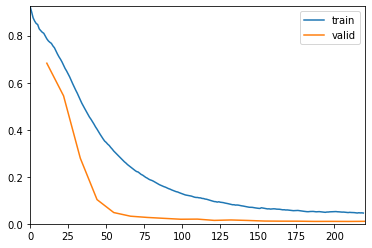

loss 0.010517026297748089: accuracy: 100.00%


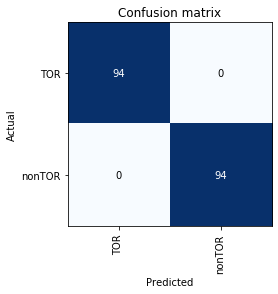

In [48]:
next(one_to_one_experiment)